In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import cv2


img = cv2.imread("annotations/annotations/trimaps/._Abyssinian_1.png")

[ WARN:0@0.008] global loadsave.cpp:248 findDecoder imread_('annotations/annotations/trimaps/._Abyssinian_1.png'): can't open/read file: check file path/integrity


In [4]:
cv2.imread("annotations/annotations/trimap/Abyssinian_201.png")

[ WARN:0@0.500] global loadsave.cpp:248 findDecoder imread_('annotations/annotations/trimap/Abyssinian_201.png'): can't open/read file: check file path/integrity


In [5]:
image_path = "images/images/Abyssinian_100.jpg"
mask_path = "annotations/annotations/trimaps/Abyssinian_100.png"

In [6]:
mask = cv2.imread(mask_path, 0)

# mask[mask==1] = 0
mask[mask==2] = 0
mask[mask>0] = 255

plt.imshow(mask, cmap='gray')

[ WARN:0@1.508] global loadsave.cpp:248 findDecoder imread_('annotations/annotations/trimaps/Abyssinian_100.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object does not support item assignment

In [7]:
image = cv2.imread(image_path, 0)

[ WARN:0@2.175] global loadsave.cpp:248 findDecoder imread_('images/images/Abyssinian_100.jpg'): can't open/read file: check file path/integrity


In [8]:
mask = cv2.imread(mask_path, 0)
image = cv2.imread(image_path, 0)

image[mask!=1] = 0
plt.imshow(image, cmap='gray')

[ WARN:0@2.326] global loadsave.cpp:248 findDecoder imread_('annotations/annotations/trimaps/Abyssinian_100.png'): can't open/read file: check file path/integrity
[ WARN:0@2.326] global loadsave.cpp:248 findDecoder imread_('images/images/Abyssinian_100.jpg'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object does not support item assignment

In [9]:
import os
from typing import Iterable, Tuple

def get_image_and_mask(list_file: str, prefix:str=".") -> Iterable[Tuple[str, str]]:
    with open(list_file, "r") as f:
        # skip first 6 row
        for _ in range(6):
            next(f)
        for line in f:
            image_name = line.split(" ")[0]
            image_path = os.path.join(prefix, "images", "images", f"{image_name}.jpg")
            image_mask = os.path.join(prefix, "annotations", "annotations", "trimaps", f"{image_name}.png")
            yield image_path, image_mask



In [10]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
from typing import List, Callable, Any, Optional, Protocol
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np

# Constant
DEFAULT_CMAP = "gray"

class Drawable(Protocol):
    def draw(self, ax: plt.Axes) -> None:
        ...


@dataclass
class DrawImage:
    data: np.array
    title: Optional[str] = None

    def draw(self, ax: plt.Axes) -> None:
        ax.imshow(self.data, cmap=DEFAULT_CMAP)
        if self.title:
            ax.set_title(self.title)
        ax.axis('off')

def show_multiple_plots(data: List[Drawable]) -> None:
    n = len(data)
    _, axes = plt.subplots(1, n, figsize=(20, 10), squeeze=False)
    for idx, ax in enumerate(axes[0]):
        item = data[idx]
        item.draw(ax)
    plt.tight_layout()
    plt.show()

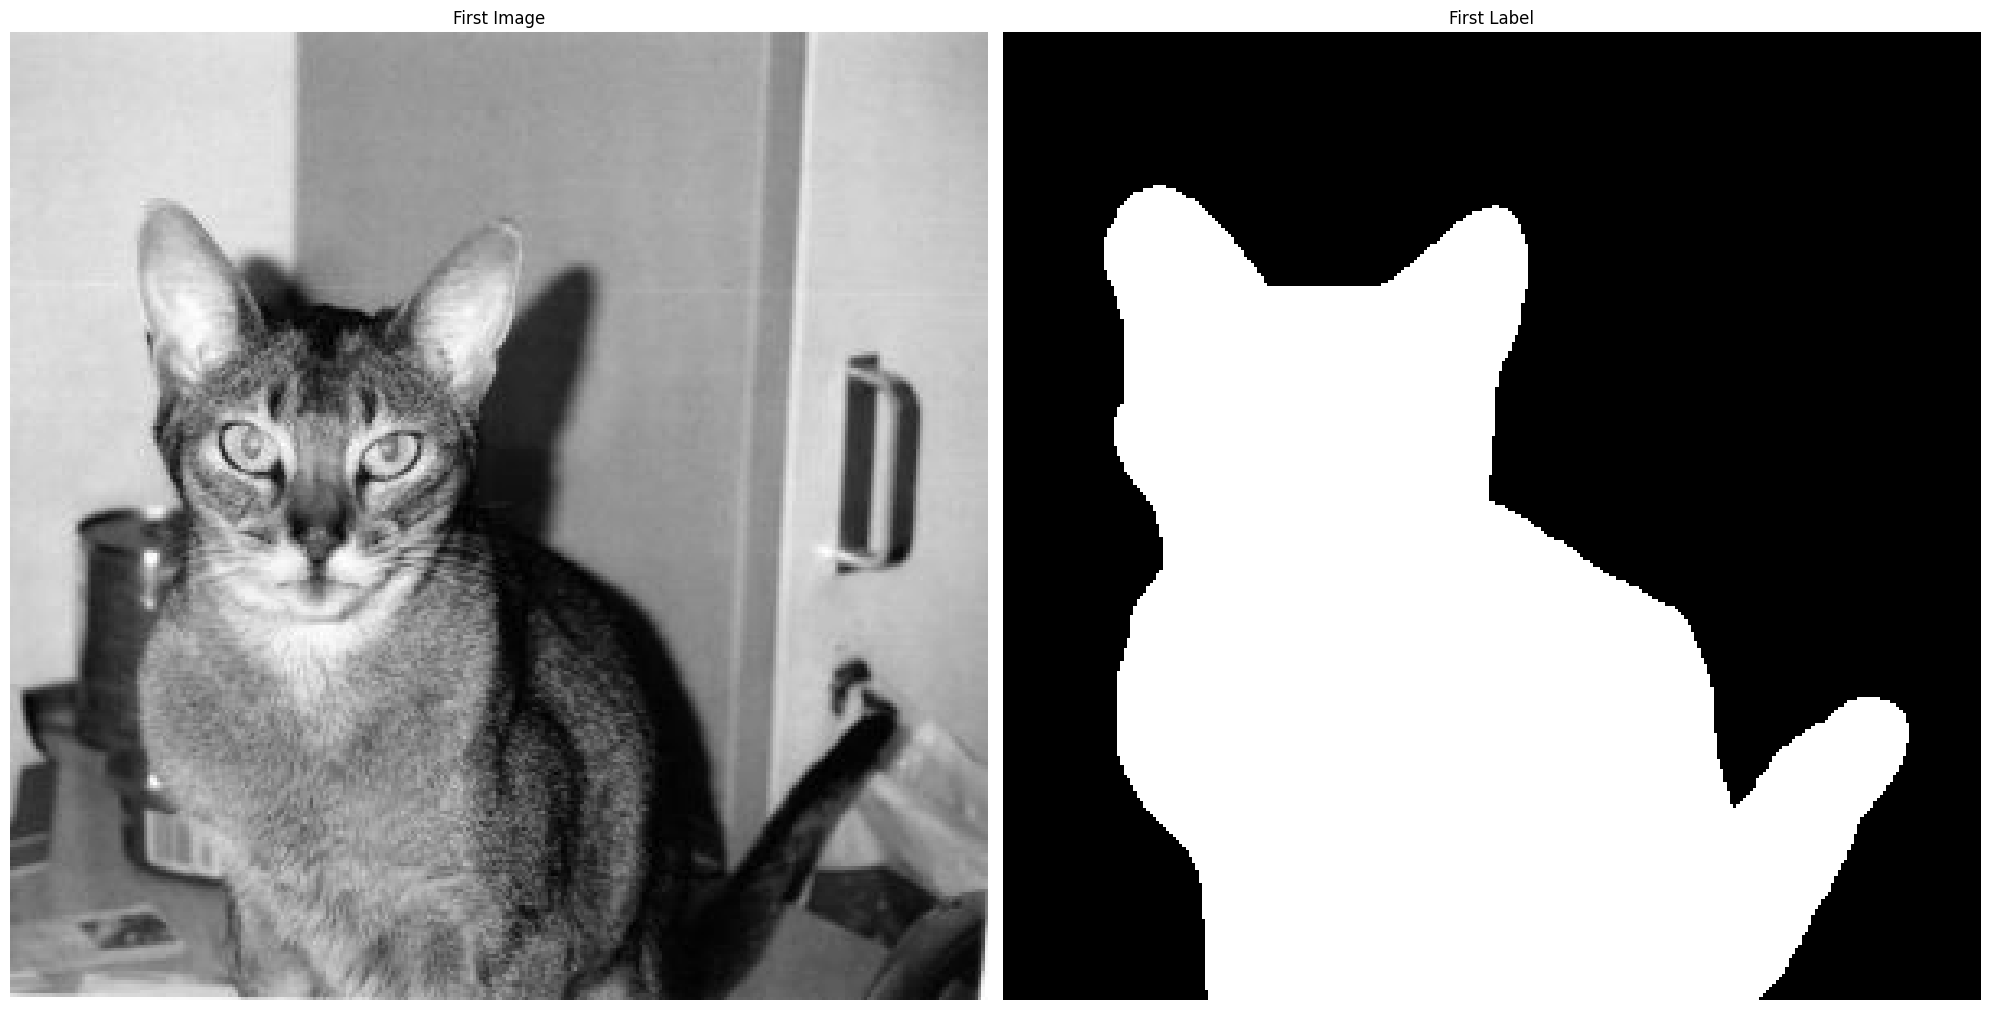

In [12]:
from typing import List, Callable, Any, Optional
from dataclasses import dataclass
import numpy as np

images_file, labels_file = tuple(zip(*list(get_image_and_mask("data/annotations/annotations/list.txt", prefix="./data"))))

first_image = cv2.imread(images_file[20], 0)
first_label = cv2.imread(labels_file[20], 0)
first_label[first_label==2] = 0
first_label[first_label>0] = 255


draw_items = [
    DrawImage(first_image, 'First Image'), 
    DrawImage(first_label, 'First Label')
]
show_multiple_plots(draw_items)

In [13]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    images_file, labels_file, test_size=0.2, random_state=42)

In [14]:
DEFAULT_TRANSFORM = A.Compose([
    A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    A.RandomCrop(height=256, width=256, always_apply=True),
    A.RandomBrightness(p=1),
    A.OneOf(
        [
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.9,
    ),

])

@dataclass
class Augmenter:
    transform: A.Compose

    def augment_image(self, image: torch.Tensor, mask: torch.Tensor):

        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()

        augmented = self.transform(image=image_np, mask=mask_np)
        augmented_image, augmented_mask = augmented['image'], augmented['mask']

        augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
        augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

        return augmented_image, augmented_mask

/home/binhn/.local/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [15]:
def preprocess_image(path: str) -> torch.Tensor:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 
        
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

def preprocess_mask(path: str) -> torch.Tensor:
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk[msk==2] = 0
    msk[msk>0] = 255
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

In [16]:
class CustomDataset(Dataset):
    def __init__(self, images_file, masks_file, input_size=(256, 256), augmentation_transforms=None):
        self.images_file = images_file
        self.masks_file = masks_file
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):
       
        image_file = self.images_file[idx]
        mask_file = self.masks_file[idx]

        image = preprocess_image(image_file)
        mask = preprocess_mask(mask_file)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

In [17]:
augmenter = Augmenter(DEFAULT_TRANSFORM)

train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augmenter.augment_image)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augmenter.augment_image)

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


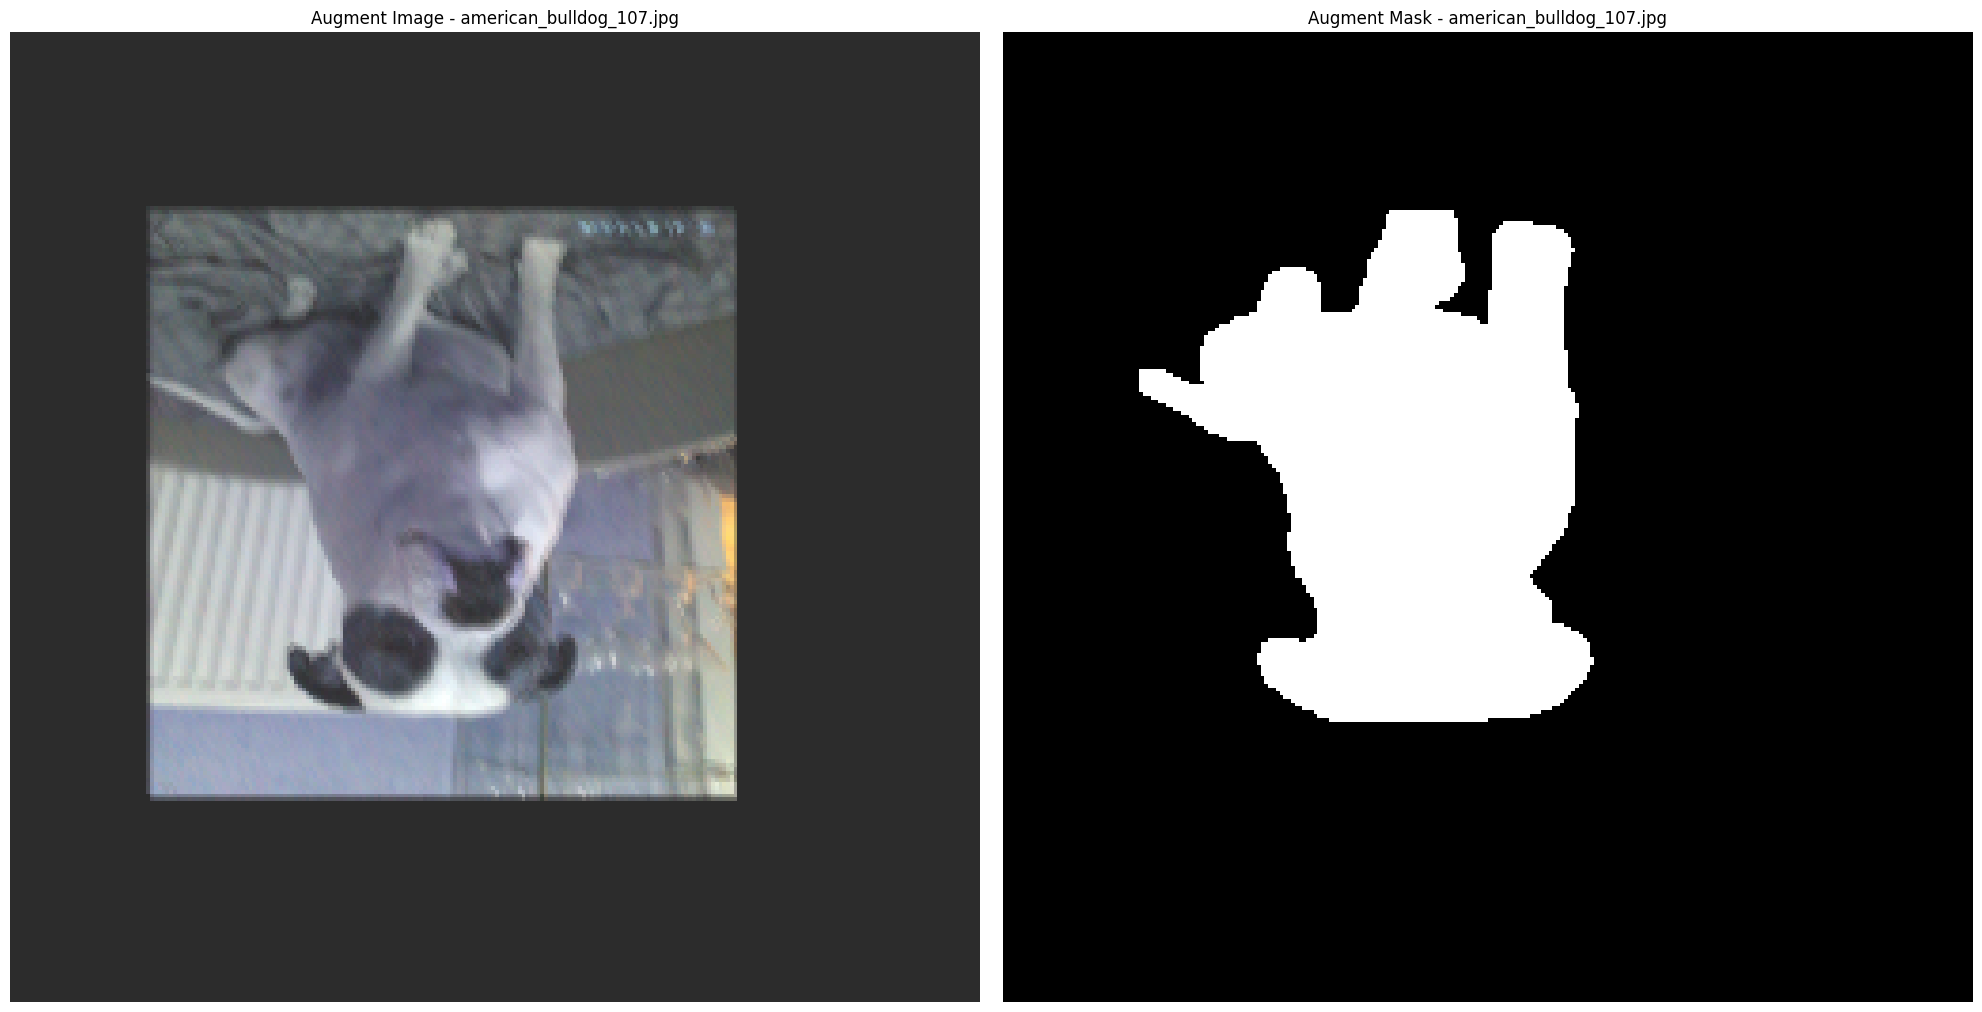

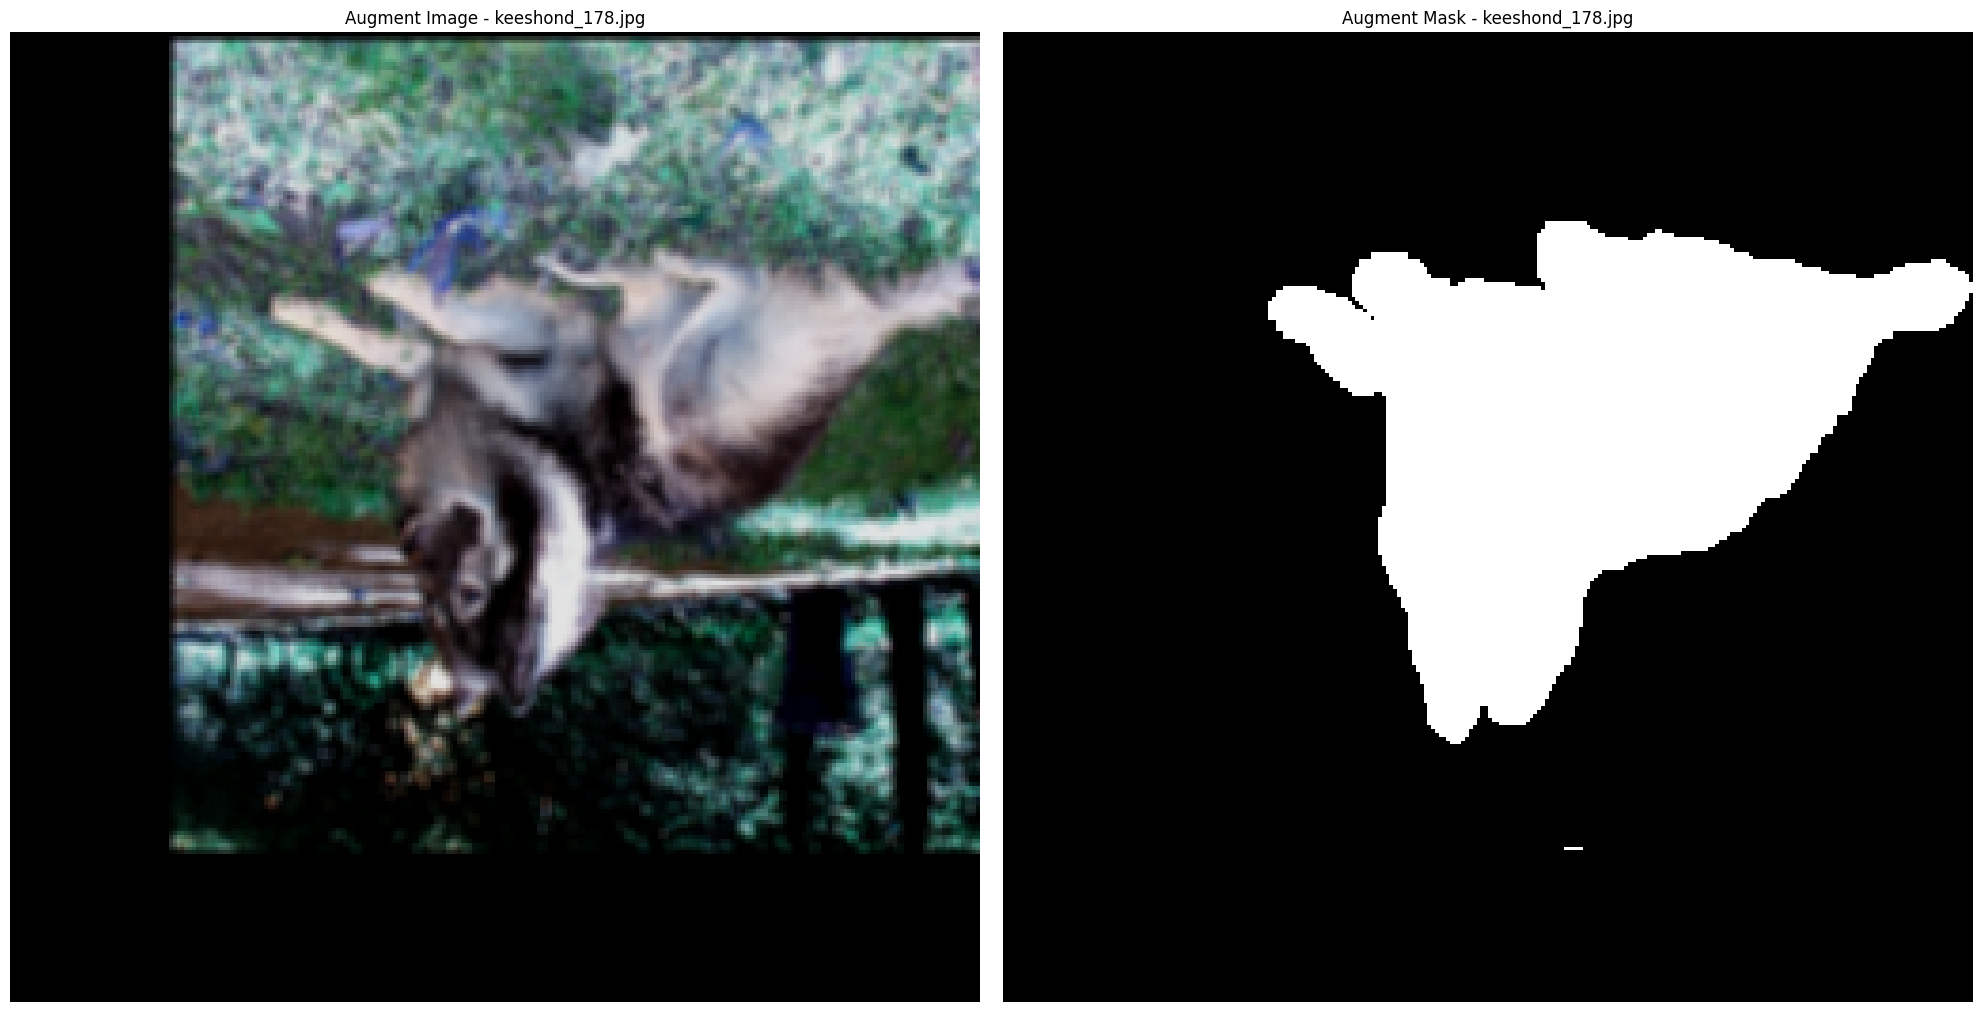

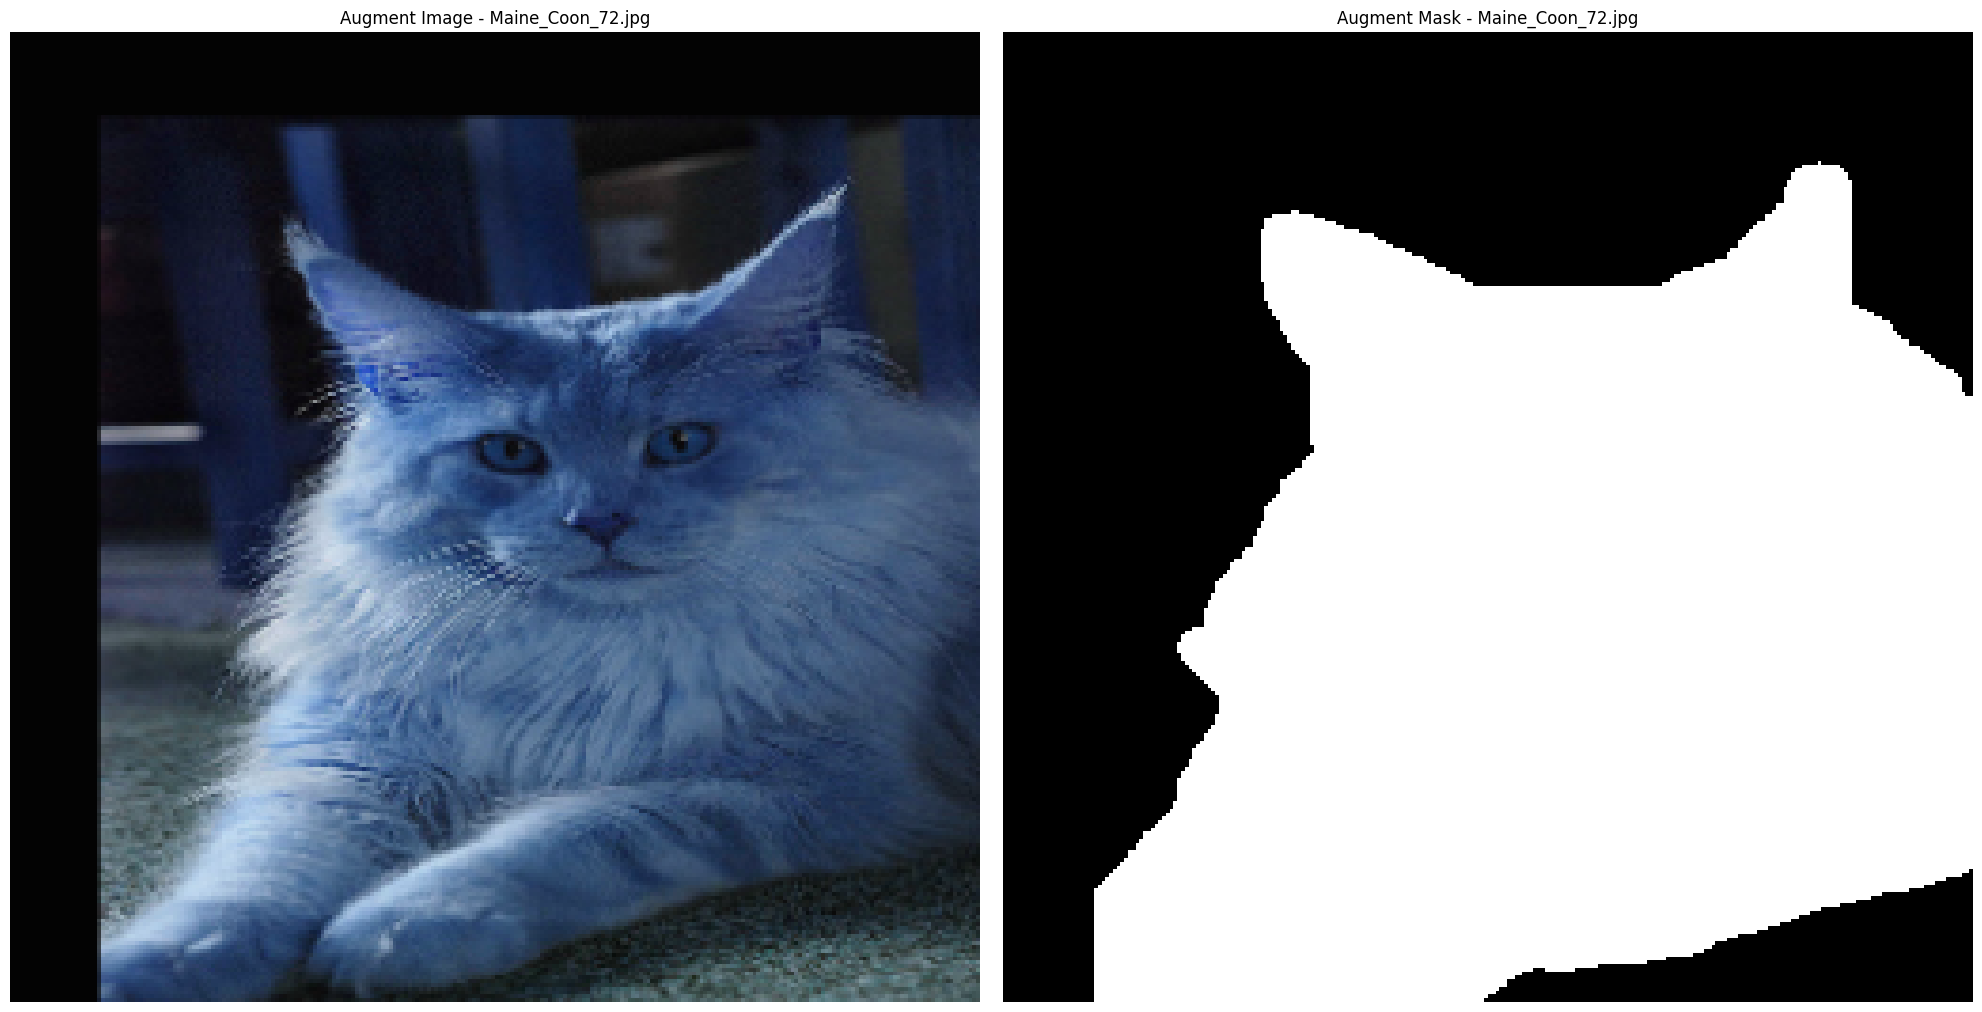

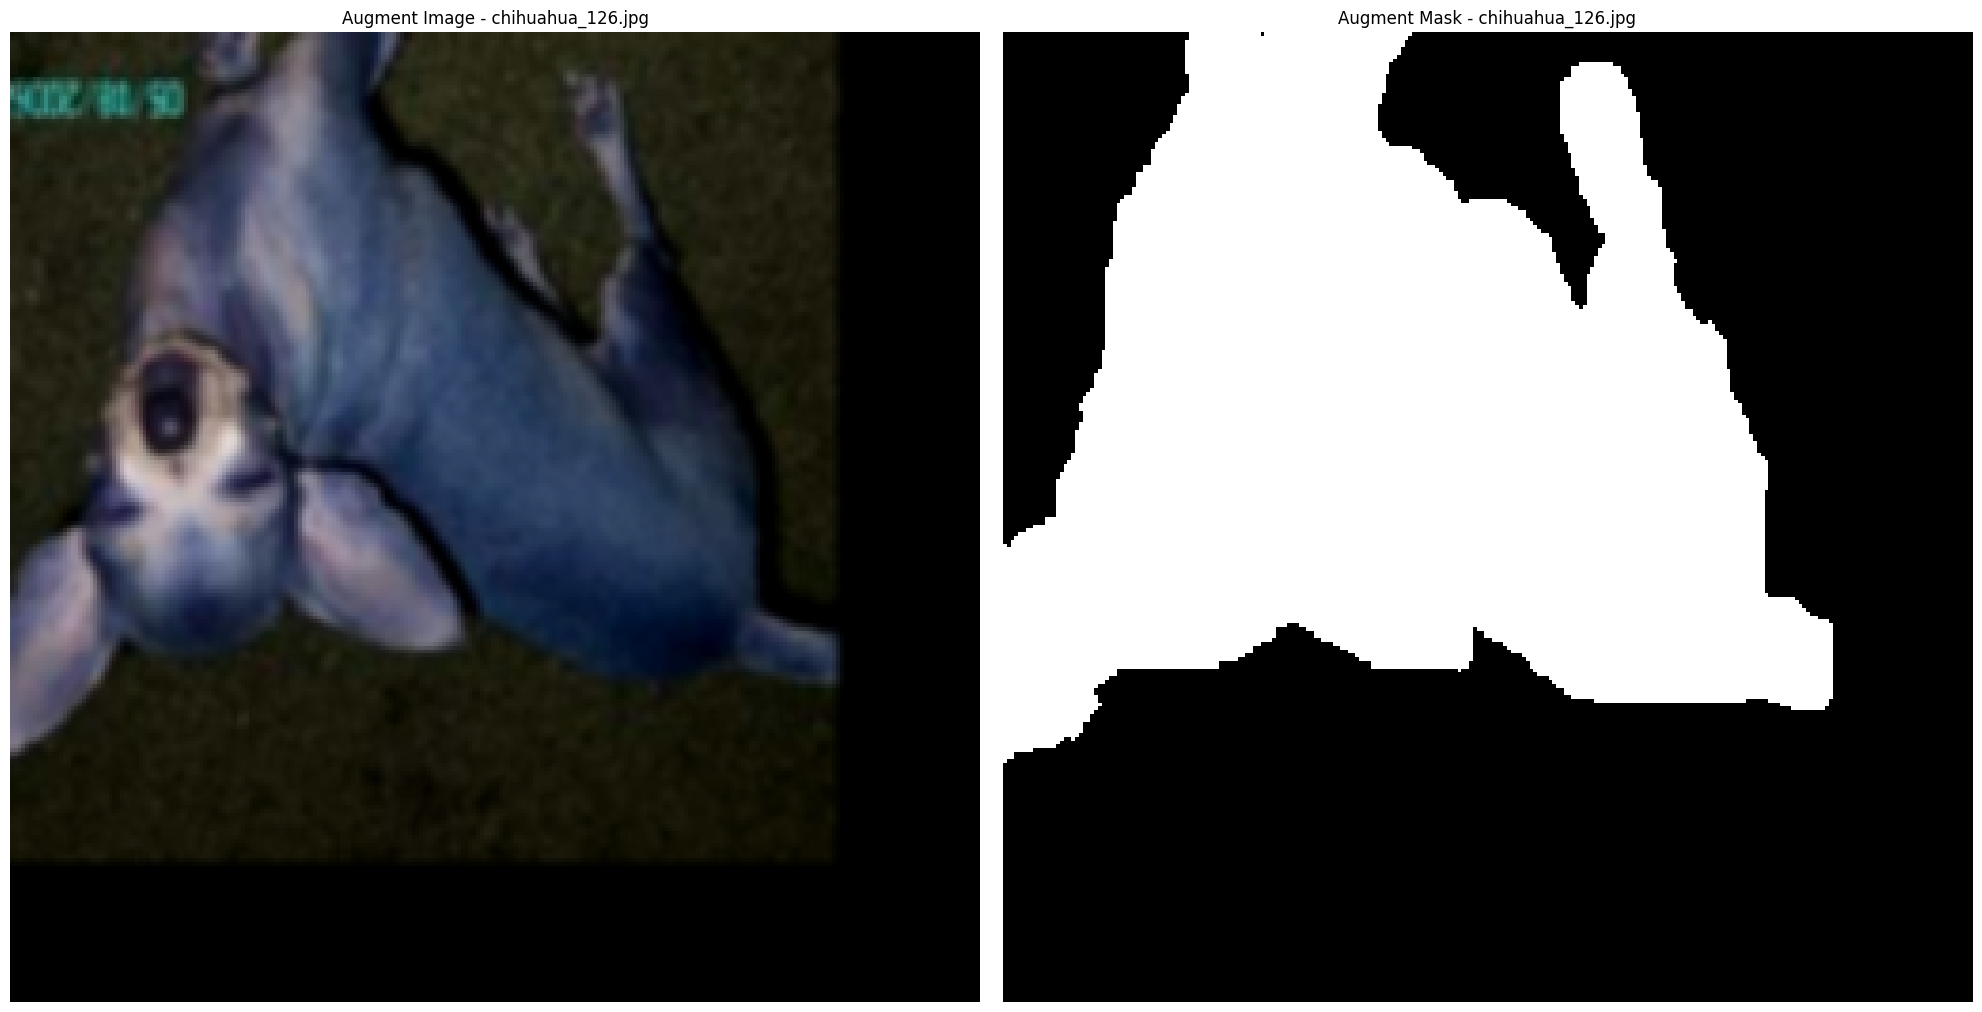

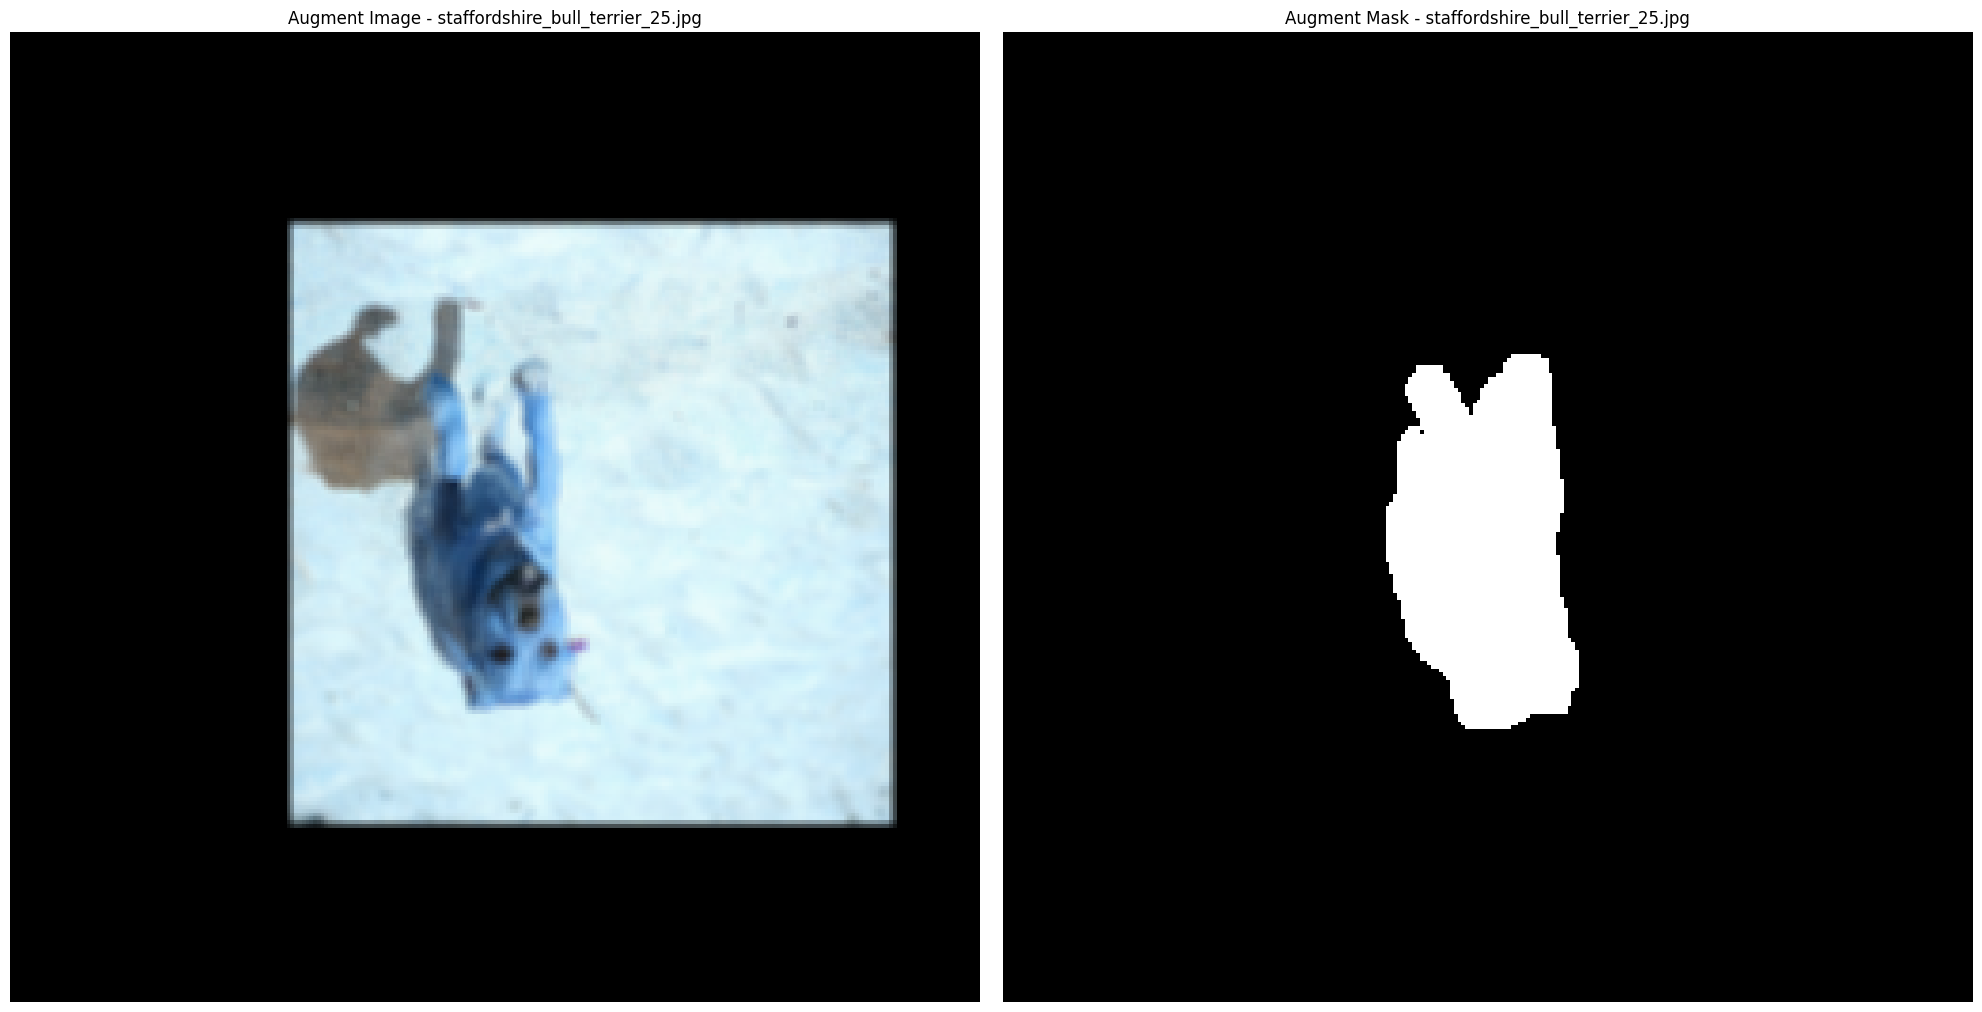

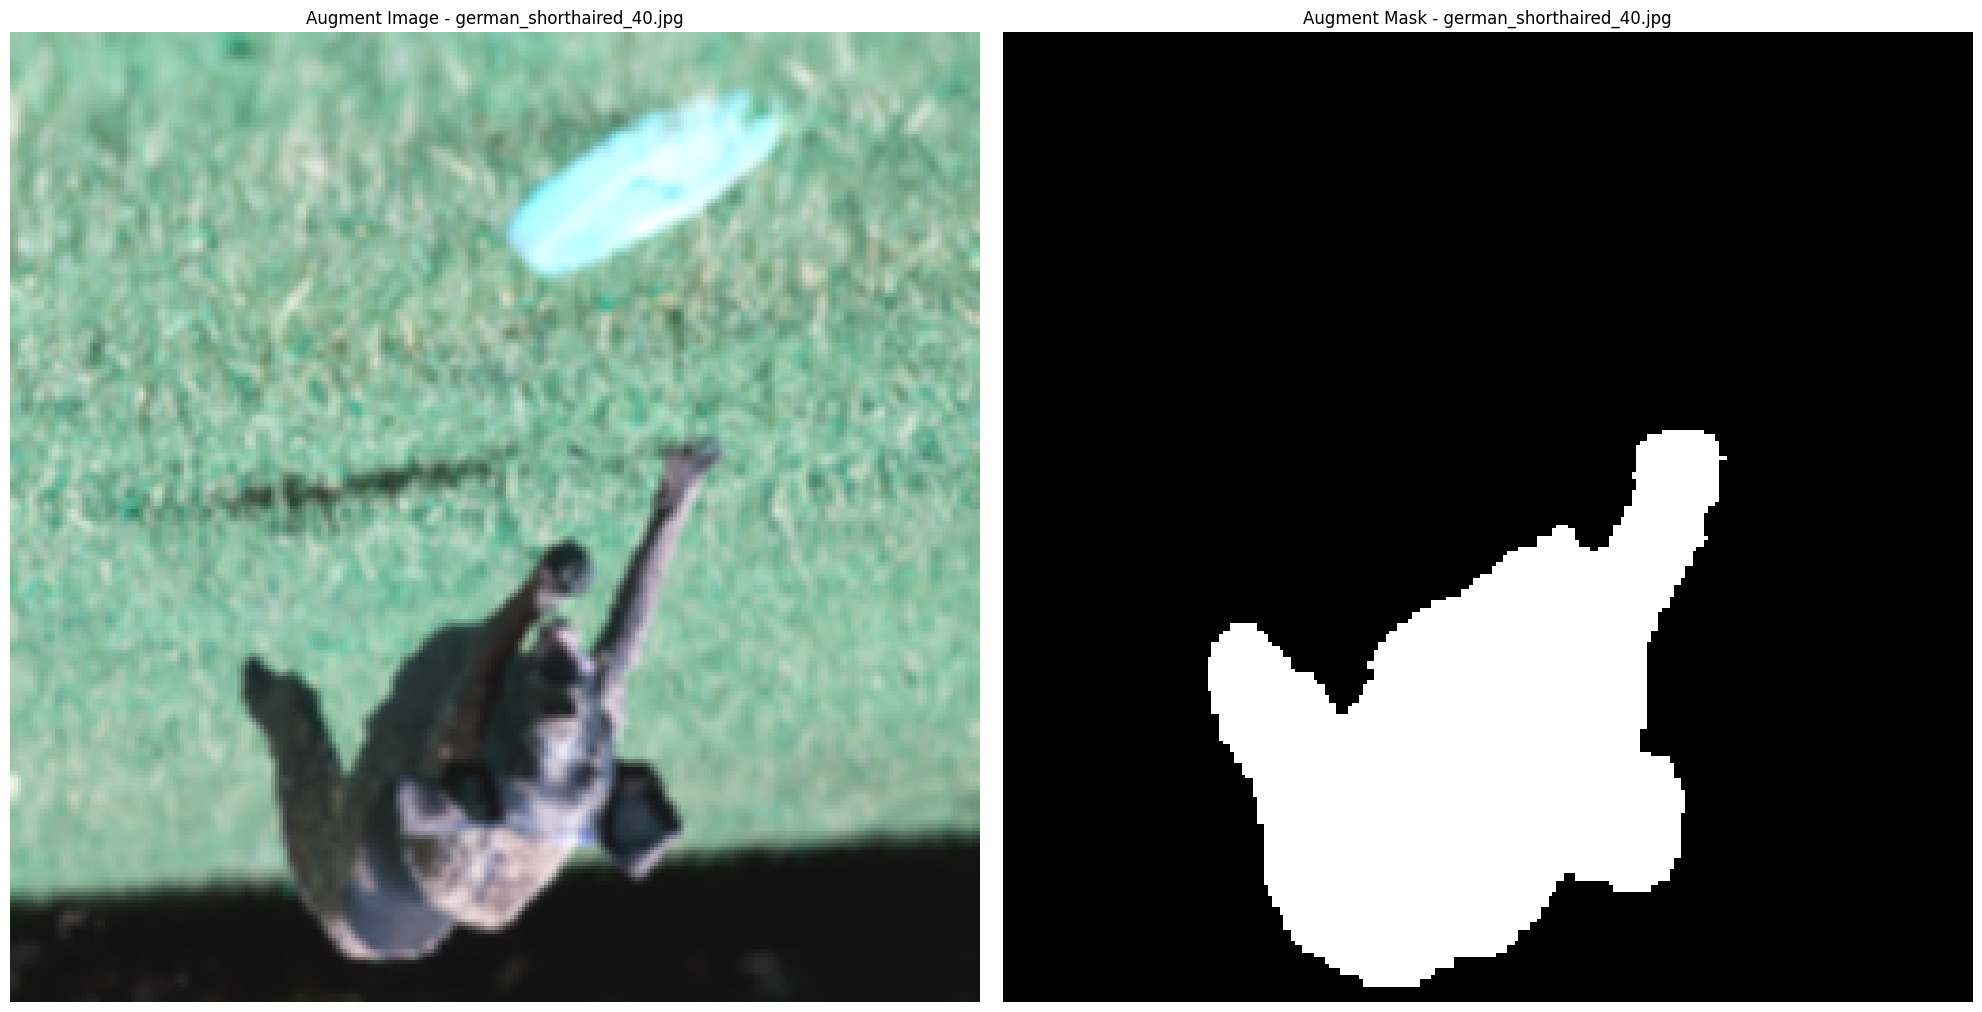

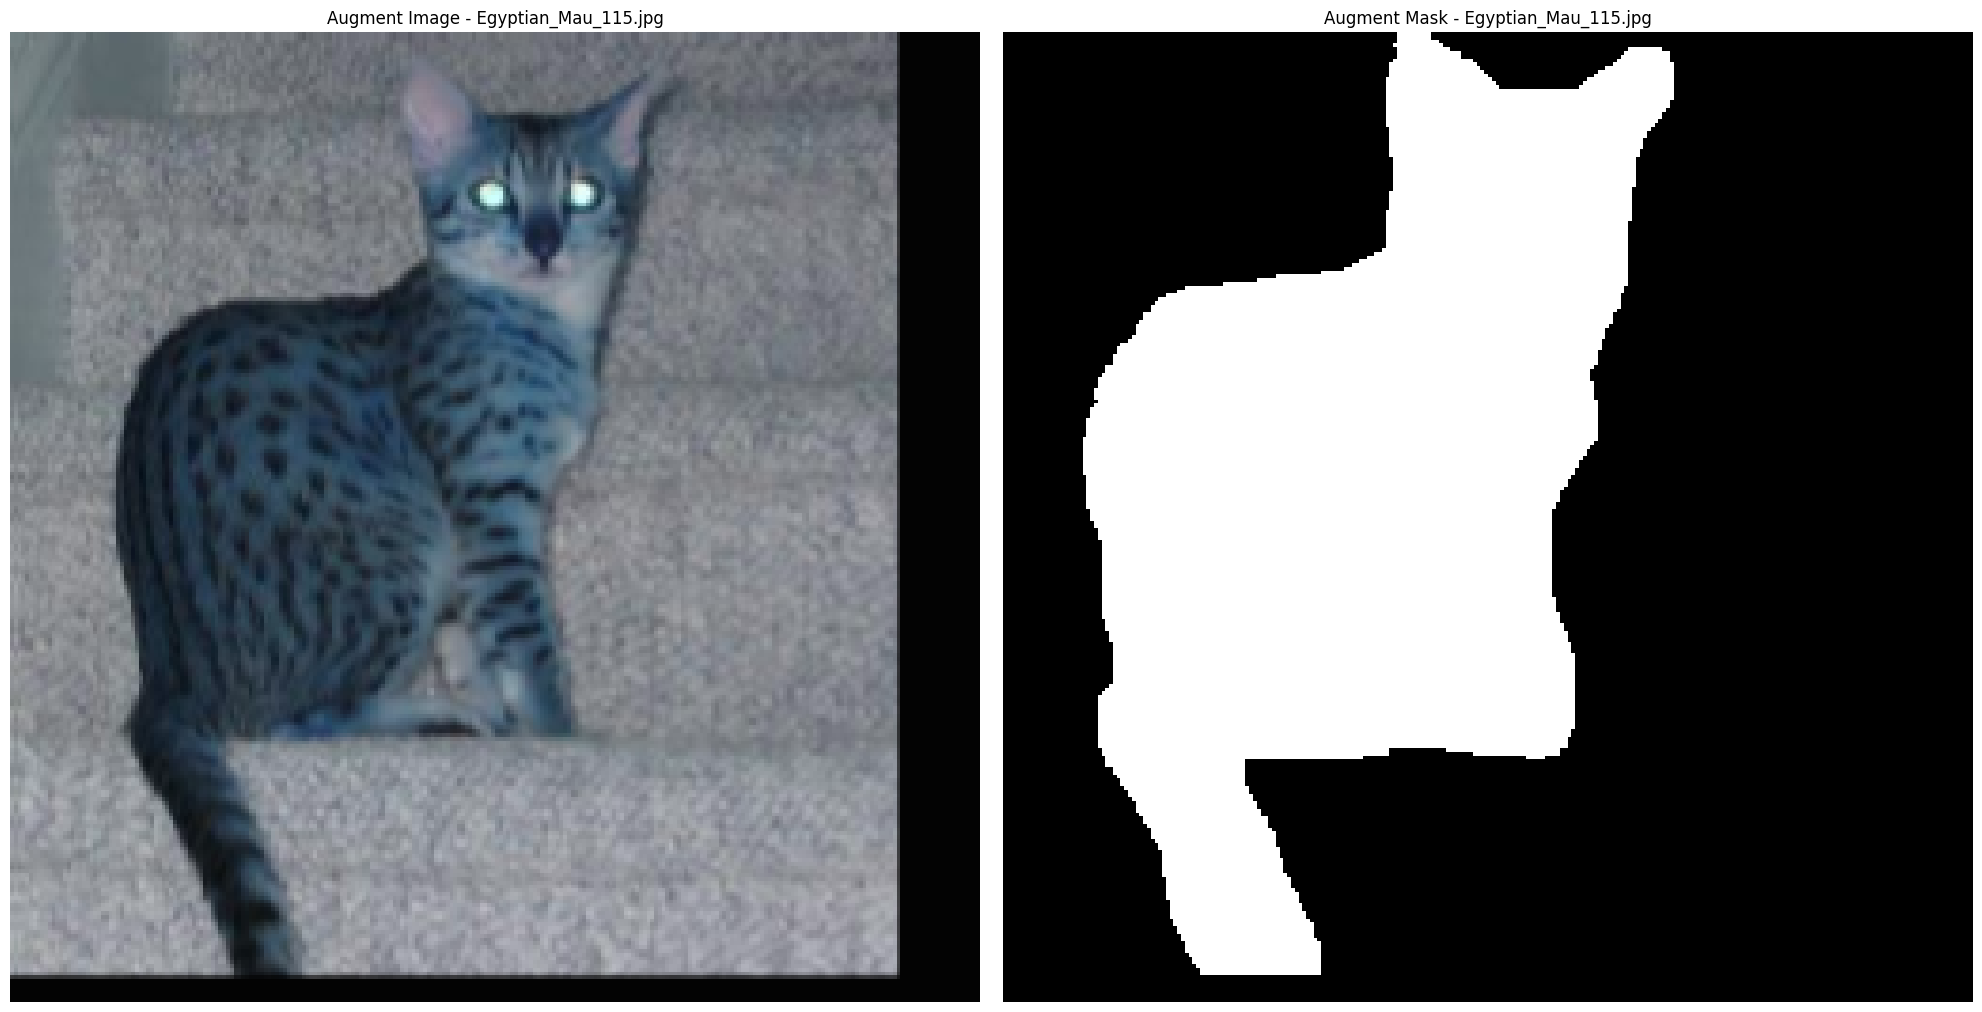

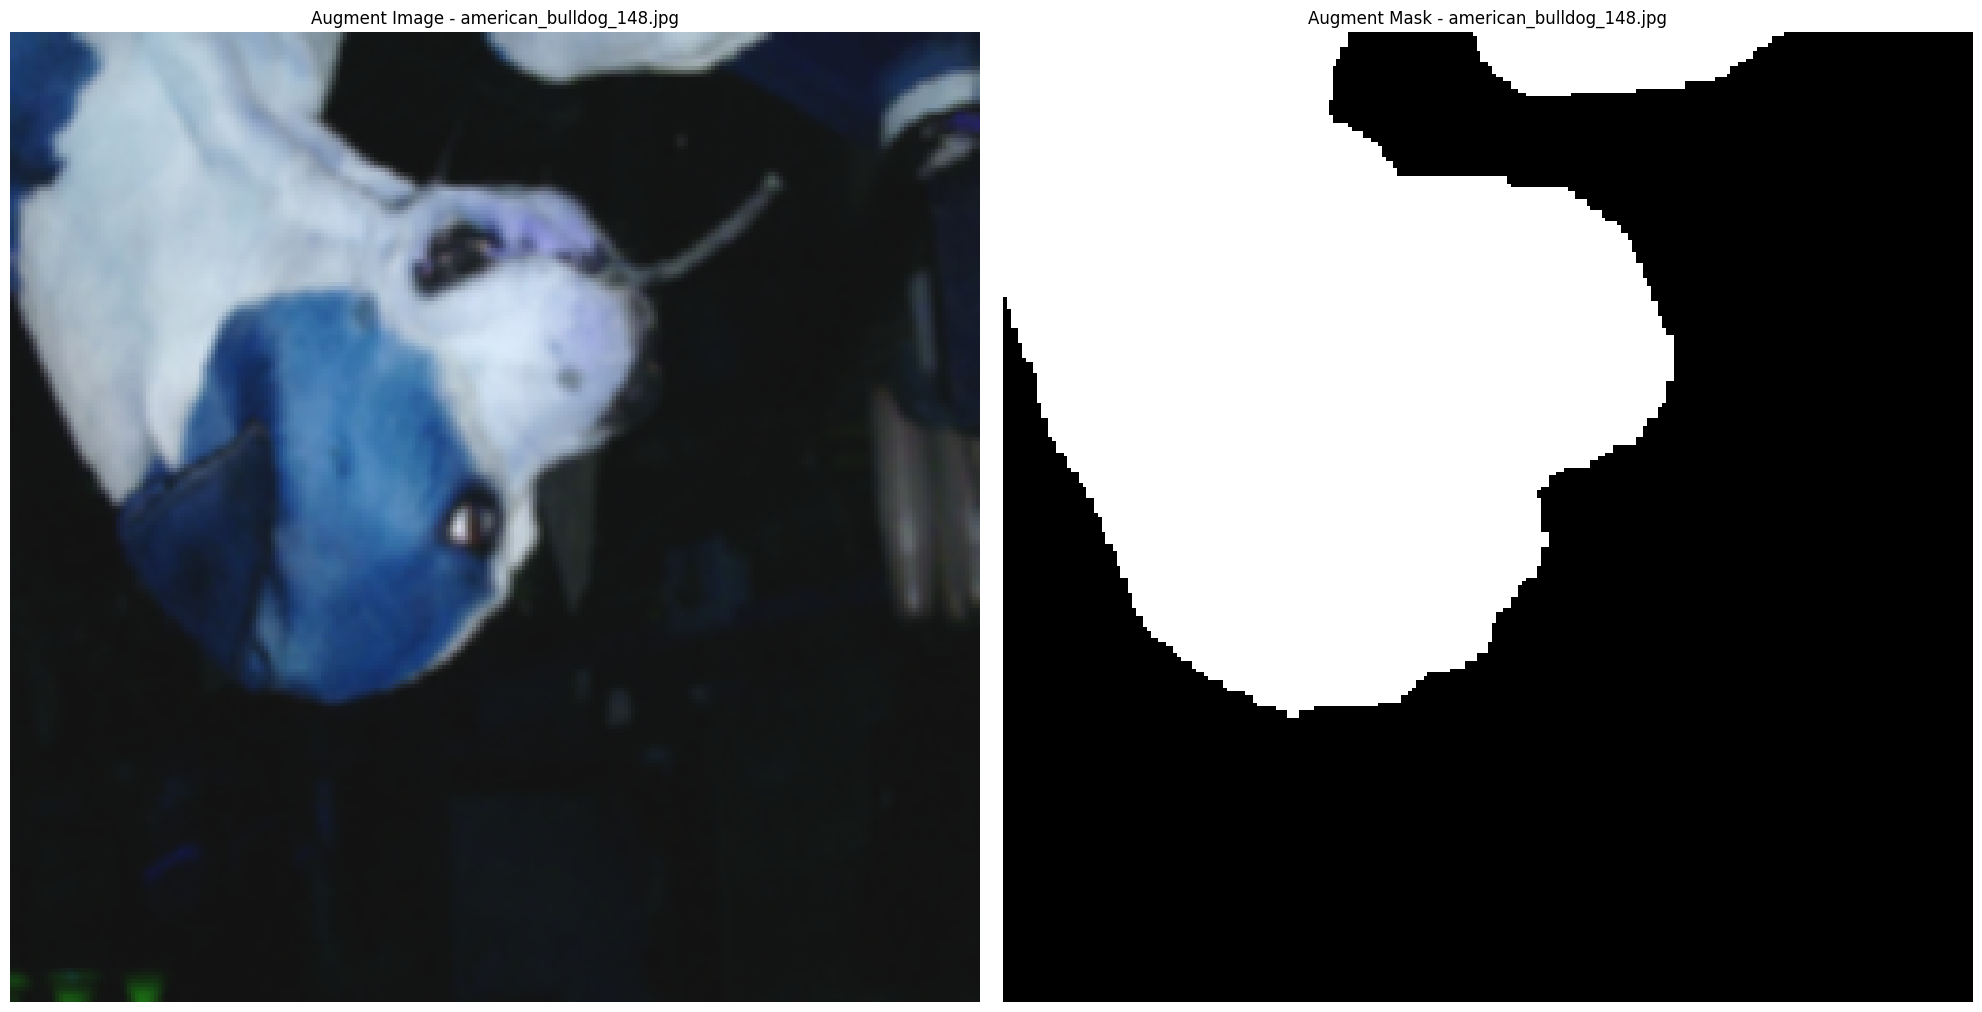

In [19]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)
    
    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
       
        image = image.permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)
        draw_items = [
            DrawImage(image, f"Augment Image - {image_filename}"),
            DrawImage(mask, f"Augment Mask - {image_filename}")
        ]
        show_multiple_plots(draw_items)
    break

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [21]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [22]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [23]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [24]:
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

In [30]:
from typing import Protocol
from dataclasses import dataclass, field

class Metric(Protocol):
    def update(self, prediction, target) -> None:
        ...
    
    def reset(self) -> None:
        ...

@dataclass
class DiceCoeff():
    name: str = "dice_coeff"
    count: int = 0
    values: List[float] = field(default_factory=list)
    
    
    def update(self, prediction, target) -> None:
        mask = np.zeros_like(prediction)
        mask[prediction >= 0.5] = 1

        inter = np.sum(mask * target)
        union = np.sum(mask) + np.sum(target)
        epsilon = 1e-6
        result = np.mean(2 * inter / (union + epsilon))
        self.values.append(result)
        self.count += prediction.shape[0]
    
    def reset(self) -> None:
        self.count = 0
        self.values = []
    
    

def one_epoch(epoch, model, optimizer, dataloader, criterion, device, metrics: List[Metric]):
    phrase = 'train'
    if phrase == 'train':
        model.train()
    elif phrase == 'test':
        model.eval()
    else:
        raise NotImplementedError
    
    batch_loss = 0.0
    
    for sample in tqdm(iter(dataloader), total=len(dataloader)):
        inputs = sample[0].to(device)
        masks = sample[1].to(device)

        masks = masks.unsqueeze(1)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phrase=='train'):
            outputs = model(inputs)

            loss = criterion(outputs, masks)

            y_pred = outputs.data.cpu().numpy().ravel()
            y_true = masks.data.cpu().numpy().ravel()
            
            for metric in metrics:
                metric.update(y_pred, y_true)

            if phrase == 'train':
                loss.backward()
                optimizer.step()

            batch_loss += loss.item() * sample[0].size(0)

    epoch_loss = batch_loss / len(dataloader)
    print('{} Loss: {:.4f}'.format("train", epoch_loss))
    return epoch_loss

In [26]:
model = AttentionUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = FocalLoss(gamma=2)

In [27]:
metrics = [DiceCoeff()]

In [40]:
one_epoch(0, model, optimizer, train_dataloader, criterion, device, metrics=metrics)

/tmp/ipykernel_9776/4212626029.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(iter(dataloader), total=len(dataloader)):


  0%|          | 0/735 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
metrics[0].reset()

In [44]:
sample = next(iter(dataloaders["training"]))
inputs = sample[0].to(device)
masks = sample[1].to(device)

masks = masks.unsqueeze(1)
optimizer.zero_grad()

with torch.set_grad_enabled(True):
    outputs = model(inputs)

    loss = criterion(outputs, masks)

    y_pred = outputs.data.cpu().numpy().ravel()
    y_true = masks.data.cpu().numpy().ravel()
            
            # for metric in metrics:
            #     metric.update(y_pred, y_true)

            # if phrase == 'train':
            #     loss.backward()
            #     optimizer.step()

            # batch_loss += loss.item() * sample[0].size(0)

In [49]:
outputs.shape[0]

8

In [38]:
len(dataloaders["training"])

735

In [37]:
dataloaders

{'training': <torch.utils.data.dataloader.DataLoader at 0x7f489a6803a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f489a683640>}